In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/casia_dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: casia_dataset/train/Tp/Tp_D_NNN_S_B_nat20007_nat20011_02213.tif  
  inflating: casia_dataset/train/Tp/Tp_D_NNN_S_B_sec00011_cha00051_00371.tif  
  inflating: casia_dataset/train/Tp/Tp_D_NNN_S_N_ani00016_ani00013_00136.tif  
  inflating: casia_dataset/train/Tp/Tp_D_NNN_S_N_ani10174_ani10173_12454.jpg  
  inflating: casia_dataset/train/Tp/Tp_D_NNN_S_N_ani10179_ani10175_12487.jpg  
  inflating: casia_dataset/train/Tp/Tp_D_NNN_S_N_ani10181_ani10180_12427.jpg  
  inflating: casia_dataset/train/Tp/Tp_D_NNN_S_N_ani10191_ani10200_12436.jpg  
  inflating: casia_dataset/train/Tp/Tp_D_NNN_S_N_ani10193_ani10195_12442.jpg  
  inflating: casia_dataset/train/Tp/Tp_D_NNN_S_N_ani10200_ani10199_12409.jpg  
  inflating: casia_dataset/train/Tp/Tp_D_NNN_S_N_ani20016_ani20017_02059.tif  
  inflating: casia_dataset/train/Tp/Tp_D_NNN_S_N_arc00030_cha00023_00250.tif  
  inflating: casia_dataset/train/Tp/Tp_D_NNN_S_N_arc00059_nat10122_11828.jpg  
 

In [10]:
import os
import numpy as np
from PIL import Image, ImageChops, ImageEnhance
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, models
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

In [4]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'

    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff

    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image

In [5]:
image_height = 256
image_width = 256
batch_size = 32

In [7]:
main_dataset_path = '/content/casia_dataset/train'

ela_data_path = 'ela_data'
os.makedirs(ela_data_path, exist_ok=True)

for class_name in os.listdir(main_dataset_path):
    class_path = os.path.join(main_dataset_path, class_name)
    ela_class_path = os.path.join(ela_data_path, class_name)
    os.makedirs(ela_class_path, exist_ok=True)

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)

        if not img_name.lower().endswith(('.jpg', '.jpeg', '.tif', '.tiff')):
            continue

        ela_img = convert_to_ela_image(img_path, quality=90)
        ela_img.save(os.path.join(ela_class_path, img_name.replace('.', '_ela.')), 'PNG')

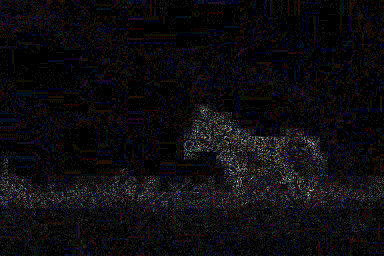

In [8]:
real_image_path = '/content/ela_data/Au/Au_ani_00001_ela.jpg'
Image.open(real_image_path)

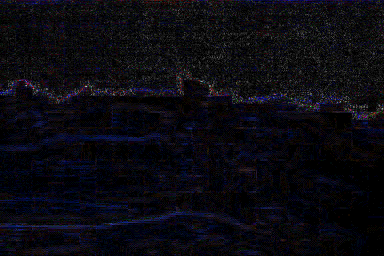

In [9]:
fake_image_path = '/content/ela_data/Tp/Tp_D_CND_M_N_ani00018_sec00096_00138_ela.tif'
Image.open(fake_image_path)

In [11]:
ela_data_path = "/content/ela_data"
test_size = 0.2

image_paths = []
labels = []

for class_folder in os.listdir(ela_data_path):
    class_folder_path = os.path.join(ela_data_path, class_folder)
    if os.path.isdir(class_folder_path):
        class_label = class_folder
        for image_filename in os.listdir(class_folder_path):
            image_path = os.path.join(class_folder_path, image_filename)
            image_paths.append(image_path)
            labels.append(class_label)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    image_paths,
    labels,
    test_size=test_size,
    random_state=42
)

In [13]:
train_df = pd.DataFrame({'filename': X_train, 'class': y_train})
test_df = pd.DataFrame({'filename': X_test, 'class': y_test})

train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='class',
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='binary'
)

Found 10048 validated image filenames belonging to 2 classes.
Found 2512 validated image filenames belonging to 2 classes.


In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (5, 5), padding='valid', activation='relu', input_shape=(image_height, image_weight, 3)),
    layers.Conv2D(32, (5, 5), padding='valid', activation='relu', input_shape=(image_height, image_weight, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

In [14]:
# model = models.Sequential([
#     layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, 3)),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Flatten(),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(1, activation='sigmoid')
# ])

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator
)

Epoch 1/30
314/314 [==============================] - 88s 241ms/step - loss: 0.5663 - accuracy: 0.7169 - val_loss: 0.3459 - val_accuracy: 0.8631
Epoch 2/30
314/314 [==============================] - 64s 203ms/step - loss: 0.3046 - accuracy: 0.8803 - val_loss: 0.2493 - val_accuracy: 0.9009
Epoch 3/30
314/314 [==============================] - 61s 195ms/step - loss: 0.2197 - accuracy: 0.9084 - val_loss: 0.2277 - val_accuracy: 0.8961
Epoch 4/30
314/314 [==============================] - 71s 226ms/step - loss: 0.1564 - accuracy: 0.9339 - val_loss: 0.2210 - val_accuracy: 0.9021
Epoch 5/30
314/314 [==============================] - 62s 197ms/step - loss: 0.1145 - accuracy: 0.9516 - val_loss: 0.2460 - val_accuracy: 0.9029
Epoch 6/30
314/314 [==============================] - 60s 191ms/step - loss: 0.0851 - accuracy: 0.9658 - val_loss: 0.2598 - val_accuracy: 0.8989
Epoch 7/30
314/314 [==============================] - 71s 227ms/step - loss: 0.0725 - accuracy: 0.9722 - val_loss: 0.3041 - val_ac

KeyboardInterrupt: ignored

In [16]:
model.save('fake_image_detection_model2.h5')

In [ ]:
from keras.models import load_model
loaded_model = load_model('/content/fake_image_detection_model.h5')